[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1nC3zMTRjp5UztroJXmz7ILcctviRdVJy)
# Deep Learning Homework - Group Zerocool

## Team Members
- **Néder Brúnó** (Neptun Code: NQKZUX)
- **Jenei Ákos** (Neptun Code: EBBUE7)
- **Tasi Gergő** (Neptun Code: BRY27P)


## Project Overview
Our project aims to create a **Convolutional Neural Network (CNN)** that can identify skin cancer in patients using images of affected areas. We will utilize the **ISIC 2024 Challenge** dataset, provided by Kaggle, which contains a wide range of dermoscopic images for skin cancer diagnosis.

For more information about the dataset, you can visit the competition page on Kaggle: [ISIC 2024 Challenge](https://www.kaggle.com/competitions/isic-2024-challenge).

---

###For the first milestone of this project, we will be:

-Downloading and importing the database.

-Removing the incomplete or unneccessary parts of the metadata provided.

-Shrinking the database, due to the small amount of positive cases compared to the negative ones.

-Loading in the images from the disk.

-Splitting the metadata and the images into Train, Validation and Test sets.



In [38]:
#install all the required packages
%pip install numpy matplotlib opencv-python rarfile tensorflow pandas scikit-learn requests patool

In [39]:
import numpy as np
import pandas as pd
import tensorflow as tf
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt
import os
import zipfile
import requests

#Amount of non cancerous images to load along with all the 393 cancerous pictures
images_to_load = 3000

In [40]:
#Downloading the database next to the notebook (credits to Kaggle: https://www.kaggle.com/competitions/isic-2024-challenge)
response = requests.get("https://dl.dropboxusercontent.com/scl/fi/druub1bxwxl5wjkwndg8c/data.zip?rlkey=bcveewvfp9hvpkz99z04n97et&st=dpqdbvl2&dl=0")
with open('data.zip', 'wb') as file:
    file.write(response.content)

In [41]:
#Unzip the downloaded data into a folder next to the notebook
with zipfile.ZipFile('data.zip', 'r') as zip_ref:
    zip_ref.extractall()

---

###We have made some changes to the database's metadata outside of the code:

-We removed collumns which's data we deemed unneccessary or that which would've ruined the learning capability of the model.

-In the age collumn there was incomplete data. We replaced the empty spaces with the average age of the patients. (58)

-Changed the raw text type of the photo's location to a one-hot-coded style, with 8 new collumns.

---

In [42]:
#Read in the entire raw database using panda
X_metadata = pd.read_csv("data/train-metadata.csv")
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

#Separate the cancerous and non cancerous photos, so we can prune the data,
#as 400k+ negative and 393 positive cases is not a good ratio to teach the model with.
X_metadata_cancer =  X_metadata[X_metadata["target"] != 0]
X_metadata_notcancer = X_metadata[X_metadata["target"] != 1]

#Select the first 'images_to_load' elements in the not cancerous pictures
#This number can be changed in the import section to fine-tune learning.
X_metadata = X_metadata_notcancer[:images_to_load]

#And then merge it together with the 393 cancerous pictures
X_metadata = pd.concat([X_metadata, X_metadata_cancer])

print(X_metadata.shape)

#Split off the ID and Target section to a different dataframe (Y)
features = ["isic_id", "target"]
Y_metadata = X_metadata.filter(features)

#Split off only the target field of the database (Y)
Y_target = X_metadata.filter(['target'])

#Delete the target collumn from the X dataframe
X_metadata = X_metadata.drop(columns=["target"])

(3393, 45)


In [55]:
#We use Min-Max scaling to increase the learning accuracy of the model

#Initialize the scaler
scaler = MinMaxScaler(feature_range=(0, 1))

#Select only the numerical columns to scale
numerical_cols = X_metadata.select_dtypes(include=['float64', 'int64']).columns

#Scale the numerical columns using apply
X_metadata[numerical_cols] = X_metadata[numerical_cols].apply(lambda x: scaler.fit_transform(x.values.reshape(-1, 1)).flatten())
print(X_metadata[:4])

        isic_id  age_approx  clin_size_long_diam_mm  tbp_lv_A  tbp_lv_Aext  \
0  ISIC_0015670    0.642857                0.094463  0.379483     0.448177   
1  ISIC_0015845    0.642857                0.004188  0.664434     0.704390   
2  ISIC_0015864    0.642857                0.111215  0.437412     0.472557   
3  ISIC_0015902    0.714286                0.102839  0.230348     0.332853   

   tbp_lv_B  tbp_lv_Bext  tbp_lv_C  tbp_lv_Cext  tbp_lv_H  tbp_lv_Hext  \
0  0.517613     0.375848  0.514322     0.439011  0.730394     0.415154   
1  0.504884     0.393312  0.663542     0.604710  0.517795     0.204435   
2  0.755377     0.655815  0.722084     0.665091  0.829204     0.541977   
3  0.399800     0.292614  0.357099     0.319450  0.783814     0.490943   

   tbp_lv_L  tbp_lv_Lext  tbp_lv_areaMM2  tbp_lv_area_perim_ratio  \
0  0.709664     0.641798        0.016307                 0.421858   
1  0.628616     0.545214        0.001717                 0.028418   
2  0.703684     0.636650       

In [53]:
#We will use 10% of the data to Validate the model and 10% to Test the model.

#Split main dataset into train and test batches.
X_train, X_test, Y_train, Y_test = train_test_split(X_metadata, Y_metadata, test_size=0.1, shuffle=True)

#Split training dataset into train and validation batches
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1/0.9)# 0.1/0.9 x 0.9 = 0.1

print("X shape:")
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)
print(" ")
print("Y shape:")
print(Y_train.shape)
print(Y_test.shape)
print(Y_val.shape)
print(" ")
print("first element:")
print(" ")
print(X_train.iloc[0])
print(" ")
print(Y_train.iloc[0])

X shape:
(2713, 44)
(340, 44)
(340, 44)
 
Y shape:
(2713, 2)
(340, 2)
(340, 2)
 
first element:
 
isic_id                         ISIC_0113821
age_approx                          0.857143
clin_size_long_diam_mm               0.08376
tbp_lv_A                            0.424516
tbp_lv_Aext                         0.392156
tbp_lv_B                            0.401764
tbp_lv_Bext                         0.369154
tbp_lv_C                            0.457772
tbp_lv_Cext                         0.405988
tbp_lv_H                            0.591291
tbp_lv_Hext                         0.471471
tbp_lv_L                            0.219052
tbp_lv_Lext                         0.183245
tbp_lv_areaMM2                      0.020108
tbp_lv_area_perim_ratio             0.106587
tbp_lv_color_std_mean                0.27229
tbp_lv_deltaA                       0.440495
tbp_lv_deltaB                       0.479275
tbp_lv_deltaL                       0.788704
tbp_lv_deltaLB                      0.196416
tb

In [45]:
#We use tensorflow's Dataset functionality, so we won't have to load all of the
#images into memory, but rather we can load the images from the disk
#whenever the model is learning, saving precious resources.

#Image loading function that Tensorflow will use to load the images
def data_generator(Y_metadata, folder_path):
    for idx, image_name in enumerate(Y_metadata.iloc[:, 0]):  # Access the first column
        image_path = os.path.join(folder_path, image_name + ".jpg")
        try:
            #The images are random sizes, but usually around 125x125
            #so we universalize them all to be 125x125
            img = cv2.resize(cv2.imread(image_path), (125, 125))

            #We normalize the images, so the model's learning accuracy improves.
            img = img / 255.0
            img = img.astype(np.float32)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            #It will become clear whether to use Normalization or Standardization for this model.
            #We will find this out in our training tests later,
            #but for now, for the sake of simplicity we will go with normalization.

            #Get the target for the current image
            y = Y_metadata['target'].iloc[idx]
            yield img, y
        except FileNotFoundError:
            print(f"Image {image_name} not found in folder.")

#Function to create the image datasets for our train-validation-test sets.
def create_dataset(metadata):
    folder_path = "data/train-image/image"
    return tf.data.Dataset.from_generator(
        lambda: data_generator(metadata, folder_path),
        output_signature=(
            #Image size 125x125 with 3 channels
            tf.TensorSpec(shape=(125, 125, 3), dtype=tf.float32),
            #Target is an integer
            tf.TensorSpec(shape=(), dtype=tf.int32)
        )
    )

#Create the train_valid_test sets
train_images = create_dataset(Y_train)
validation_images = create_dataset(Y_val)
test_images = create_dataset(Y_test)

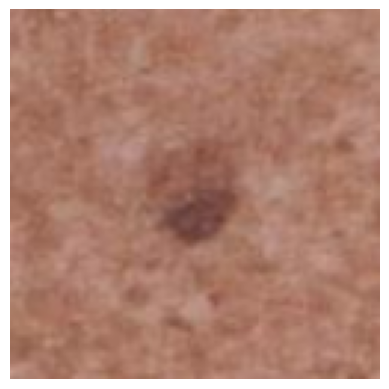

(125, 125, 3)
[[[0.6784314  0.4862745  0.43137255]
  [0.67058825 0.47843137 0.42352942]
  [0.6745098  0.48235294 0.42352942]
  ...
  [0.69803923 0.50980395 0.43137255]
  [0.7019608  0.5137255  0.43529412]
  [0.7137255  0.5254902  0.44705883]]

 [[0.654902   0.4627451  0.40784314]
  [0.6627451  0.47058824 0.4117647 ]
  [0.68235296 0.49019608 0.43137255]
  ...
  [0.6901961  0.5019608  0.42352942]
  [0.69411767 0.5058824  0.42745098]
  [0.69803923 0.50980395 0.43137255]]

 [[0.65882355 0.46666667 0.4117647 ]
  [0.6745098  0.48235294 0.42745098]
  [0.69803923 0.50980395 0.4509804 ]
  ...
  [0.6862745  0.49803922 0.41960785]
  [0.6862745  0.49803922 0.41960785]
  [0.6862745  0.49803922 0.41960785]]

 ...

 [[0.7764706  0.6039216  0.54901963]
  [0.7529412  0.5803922  0.5176471 ]
  [0.73333335 0.56078434 0.5058824 ]
  ...
  [0.6431373  0.45882353 0.38431373]
  [0.65882355 0.47843137 0.40392157]
  [0.6901961  0.5058824  0.43529412]]

 [[0.74509805 0.5764706  0.52156866]
  [0.7176471  0.5529412

In [54]:
#Visualize a sample image from the dataset
for image, label in train_images.take(1):
    plt.imshow(image.numpy())
    plt.axis('off')
    plt.show()
    print(image.numpy().shape)
    print(image.numpy())